<h1>
    <center>
    TMA4215 Project 2


### Table of contents
#### 1. Introduction
#### 2. Algorithm 
#### 3. Deciding parameters

3.1 The batchsize 

3.2 The number of hidden layers, $K$

3.3 The value of the learning parameter, $\tau$

3.4 The dimension of the input data in the hidden layers $d$

3.5 The stepsize $h$


#### 4. Training and testing with suggested functions
4.1 $F(y) = 1-\cos(y)$

4.2 $G(y_1, y_2) = \frac{1}{2}(y_1^2 + y_2^2)$

4.3 Known Hamiltonian

4.3 Unknown Hamiltonian

#### 5. Determine the gradient 


### 1. Introduction

The purpose of this project is to use a neural network to train approximations of Hamiltonian function, derive and implement formulas for computing the gradient of the trained function and use those to implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian function. 

This report present the algorithm, ...

### 2. Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams

The functions above are imported from separate files and are used to generate input data batches from comma seperated files and to write our trained values to a file as well as reading these values from a file. 

The algorithm is divided into several smaller codeblocks with the purpose of making the code easy to follow. Principally, the algorithm's parts is to transform input data between the layers in the network, decide the gradients of the objective function, $J = \frac{1}{2} \|Z-c\| $, with respect to weights, biases, $\omega$ and $\mu$ and optimalize the network with respect to those. Additionally, several utility functions is defined to be used in the algorithm.

In [3]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

The functions above generate random initial values drawn from a standard normal distribution to the weights, $W_k$, the biases, $b_k$, $\omega$ and $\mu$. These random values causes some marginal differences between runs of the same dataset. 

In [4]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K+1,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K+1):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

Defines the functions getZ and getP, where getZ executes linear transformations $\Phi_k: Z_k \rightarrow Z_{k+1}$ based on the weights and biases and returns the matrix $Z$ and getP returns an utility matrix used in calulations of derivatives of the objective function with respect to the weight and biases. Furthermore, getYpsilon is defined and returns a vector of the function values in the last layer in the network and the objective funksjon $J$ is defined as a measure of the difference between the resulting trained values and the exact function values. 

In [5]:
def getdJdmu(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdmu = np.transpose(eta_div(u))@(ypsilon-c)
    return dJdmu

def getdJdomega(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdOmega = Z[K] @ ((ypsilon - c) * eta_div(u))
    return dJdOmega

def getdJdW(P, Z, W, b, K, h, sigma_div):
    dJdW = np.zeros_like(W)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdW[k] = h*(P[k+1]*sigma_div(u))@ np.transpose(Z[k])  
    return dJdW

def getdJdb(P, Z, W, b, K, h, sigma_div):
    dJdb = np.zeros_like(b)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdb[k] = h*(P[k+1]*sigma_div(u))@np.ones((Z.shape[2],1))
    return dJdb

Functions to obtain the derivatives of the objective function with respect to weights and biased is defined. 

In [6]:
def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

def plain(theta, tau, dJdtheta):
    return theta - tau*dJdtheta

def adam(theta,alpha,m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return theta-R,m,v

The functions above is used to optimize the weights, biases, $\omega$ and $\mu$ in different ways, which will be compared later on in this report.

In plain vanilla gradient descent, one follows the gradient in decreasing direction and the learning parameter $\tau$ determine how far one shall follow it. 

In Adam descent method, one follows the gradient with different length depending on different parameters. The parameters $m$ and $v$ represent respectively a kind of mean value and squared mean value of the previous iterations gradients. The function getMandV initialize $m$ and $v$ to be either zer, the zerovector or the zeromatrix depending on inputdata's dimension. 

In [7]:
def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

Above, the activating function $\sigma$, which is used in the transformation $\Phi_k: Z_k \rightarrow Z_{k+1}$, and the function $\eta$, used in projection from last layer on a scalar $z$, is defined. The derivatives of $\sigma$ and $\eta$ is also defined and will be used in calculations of the gradient of the objective function.

In [8]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

A function to scale data in terms of a min-max transformation that guaranteed that the data have all its components in the interval $[\alpha, \beta]$ is defined. This is desirable since some functions is acting component-wise on other functions....?

In [9]:
def successrate(ypsilon, c, tol):
    sum = 0
    for i in range(ypsilon.shape[0]):
        if isclose(ypsilon[i][0], c[0][i], abs_tol = tol):
            sum +=1
    return sum/ypsilon.shape[0]

si noe fornuftig her etterhver

In [10]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, tol, chunksize, optimization):
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        print("d must be larger than d0")
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    ypsilon = np.zeros_like(c0)
    
    for i in range(N):
               
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            print("chunksize must be smaller than I")       
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = plain(mu, tau, dJdmu)
            omega = plain(omega, tau, dJdomega)
            W = plain(W, tau, dJdW)
            b = plain(b, tau, dJdb)
        
        elif optimization == "adam":
            mu, mmu,vmu = adam(mu,tau,mmu,vmu,dJdmu,i+1)
            omega, momega,vomega = adam(omega,tau,momega,vomega,dJdomega,i+1)
            W, mW,vW = adam(W,tau,mW,vW,dJdW,i+1)
            b, mb,vb = adam(b,tau,mb,vb,dJdb,i+1)
        
        if (J[i]/chunksize) < tol:
            break
        
    return mu, omega, W, b, J, ypsilon, i

In [11]:
def testing(yTest, cTest, W, b, omega, mu, K, d, I, h, sigma, eta):

    #scaling of input
    yTilde = yTest
    cTilde, ac, bc = scale(cTest)

    #finds input shape
    d0 = yTest.shape[0]
    
    if d > d0:
        zero = np.zeros((d-d0,I))
        yTilde = np.vstack((yTilde,zero))
    
    zTest = getZ(yTilde, W, b, K, d, I, h, sigma)
    ypsilonTilde = getYpsilon(zTest, omega, mu, K, eta)

    #rescaling of input
    ypsilonTest = inverseScale(ypsilonTilde, ac, bc)

    return ypsilonTest

The training algorithm returns trained values of the weights, biases, $\omega$ and $\mu$ as well as the objective function and $\Upsilon$. 

### 3. Deciding parameters

In [12]:
N = 2500
tol = 1E-10 

batch0 = generate_data(0)

p0_tilde = batch0['P']
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])
I_0 = p0_tilde.shape[1]

In this section, optimal choices for the parameters $K$, $\tau$, $d$ and $h$ will be investigated. All the following tests are based on that first batch of values, enclosed to the project description, for the unknown Hamiltonian function. Furthermore, the number for training series is chosen to be 2500 in all of the cases, and the tolerance is for that reason very small for so that one can guarantee that the training algorithm does not obtain a tolerated value of the objective function within the 2500 training series.

#### 3.1 The batchsize

In [18]:
#define variables for this test
batchsize_list = np.arange(I_0/4, I_0+1,I_0/4).astype(int) 
d_0 = p0_tilde.shape[0]    
h = 0.1     
tau = 0.0001  
K = 50

#define lists of filenames where the trained parameters will be stored 
filenames_batchsize_A = []
filenames_batchsize_P = []
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    filenames_batchsize_A.append('trainingParams_Abatch{}'.format(batchsize))
    filenames_batchsize_P.append('trainingParams_Pbatch{}'.format(batchsize))

In [ ]:
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    #train for different batchsizes with adam descent 
    mu_A0, omega_A0, W_A0, b_A0, J_Abatch, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Abatch, itr_A0, filename = filenames_batchsize_A[i])
    
    #train for different batchsizes with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Pbatch, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pbatch, itr_P0, filename = filenames_batchsize_P[i])

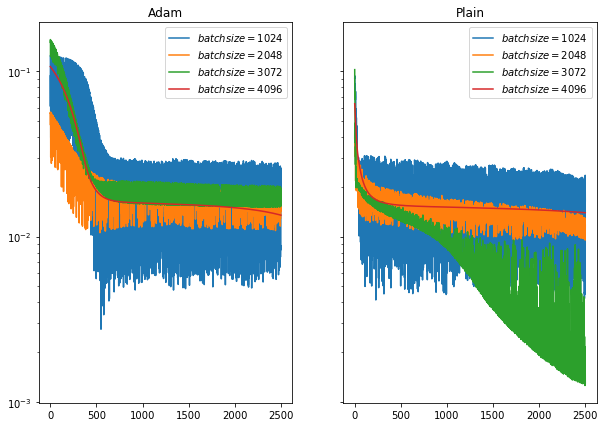

In [22]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

#plot adam
ax = axs[0]
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Abatch, itr_A0 = readParams(K, d_0, batchsize, N, filename = filenames_batchsize_A[i])
    ax.plot(np.linspace(0,N,N), J_Abatch/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()

#plot plain
ax = axs[1]
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pbatch, itr_P0 = readParams(K, d_0, batchsize, N, filename = filenames_batchsize_P[i])
    ax.plot(np.linspace(0,N,N), J_Pbatch/batchsize, label = r"$batchsize ={}$".format(batchsize))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

As one can observe from the plots, the value of the objective function will not converge but oscillate around the convergent value for batchsizes smaller than the size of the batch that the parameters are trained by. This implies that the use of a smaller batchsize in further testing will make the convergence plot oscillating.............. nah

In investigation of the parameters $K$, $\tau$, $d$ and $h$ we will use the whole batchsize as input values, since this will give a

In [ ]:
OLD BELOW

#### 3.2 The number of hidden layers, $K$

In [55]:
#define variables for this test
batchsize = I_0
d_0 = p0_tilde.shape[0]      
h = 0.1      
tau = 0.001   
K_list = np.arange(25,101,25) 

#define lists of filenames where the trained parameters will be stored
filenames_K_A = []
filenames_K_P = []
for i in range(len(K_list)):
    K = K_list[i]
    filenames_K_A.append('trainingParams_AK_{}'.format(K))
    filenames_K_P.append('trainingParams_PK_{}'.format(K))

In [ ]:
for i in range(len(K_list)):
    K = K_list[i]
    #train for different K values with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_AK, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_AK, itr_A0, filename = filenames_K_A[i])
    
    #train for different K values with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_PK, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_PK, itr_P0, filename = filenames_K_P[i])

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

#plot adam
ax = axs[0]
for i in range(len(K_list)):
    K = K_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_AK, itr_A0 = readParams(K, d_0, batchsize, N, filename = filenames_K_A[i])
    ax.plot(np.linspace(0,N,N), J_AK/batchsize, label = r"$K ={}$".format(K))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


#plot plain
ax = axs[1]
for i in range(len(K_list)):
    K = K_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_PK, itr_P0 = readParams(K, d_0, batchsize, N, filename = filenames_K_P[i])
    ax.plot(np.linspace(0,N,N), J_PK/batchsize, label = r"$K ={}$".format(K))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

The graphs illutrates that there is.....

In [ ]:
old below 

#### 3.3 The value of the learning parameter $\tau$

In [23]:
#define variables for this test
batchsize = I_0
d_0 = p0_tilde.shape[0]      #dimension of layers for F(y)
h = 0.1      #stepsize
tau_list = np.linspace(0.001, 0.01, 4)   #learning parameter
K = 50 

#define lists of filenames where the trained parameters will be stored
filenames_tau_A = []
filenames_tau_P = []
for i in range(len(tau_list)):
    tau = tau_list[i]
    filenames_tau_A.append('trainingParams_Atau_{}'.format(tau))
    filenames_tau_P.append('trainingParams_Ptau_{}'.format(tau))

In [ ]:
for i in range(len(tau_list)):
    tau = tau_list[i]

    #train for different tau values with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Atau, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Atau, itr_A0, filename = filenames_tau_A[i])
    
    #train for different tau values with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Ptau, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ptau, itr_P0, filename = filenames_tau_P[i])

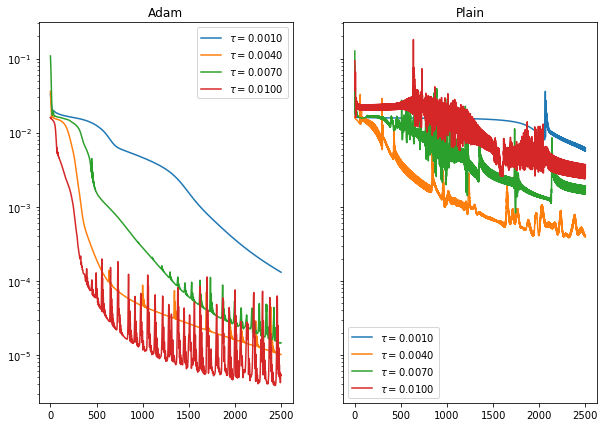

In [24]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

#plot adam
ax = axs[0]
for i in range(len(tau_list)):
    tau = tau_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Atau, itr_A0 = readParams(K, d_0, batchsize, N, filename = filenames_tau_A[i])
    ax.plot(np.linspace(0,N,N), J_Atau/batchsize, label = r"$\tau =%.4f$"%tau)
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


#plot plain
ax = axs[1]
for i in range(len(tau_list)):
    tau = tau_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ptau, itr_P0 = readParams(K, d_0, batchsize, N, filename = filenames_tau_P[i])
    ax.plot(np.linspace(0,N,N), J_Ptau/batchsize, label = r"$\tau =%.4f$"%tau)
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

The graphs illustrates that .... 

In [ ]:
old below

#### 3.4 The dimension of the input data in the hidden layers $d$

In [49]:
#defines variable for this test
batchsize = I_0
d_0_list = np.array([3,4,5,6])  
h = 0.1      
tau = 0.001 
K = 50 

#define lists of filenames where the trained parameters will be stored
filenames_d_A = []
filenames_d_P = []
for i in range(len(d_0_list)):
    d0 = d_0_list[i]
    filenames_d_A.append('trainingParams_Ad_{}'.format(d0))
    filenames_d_P.append('trainingParams_Pd_{}'.format(d0))

In [51]:
for i in range(len(d_0_list)):
    d0 = d_0_list[i]
    
    #train for different values of d with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Ad0, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ad0, itr_A0, filename = filenames_d_A[i])
    
    #train for different values of d with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Pd0, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pd0, itr_P0, filename = filenames_d_P[i])

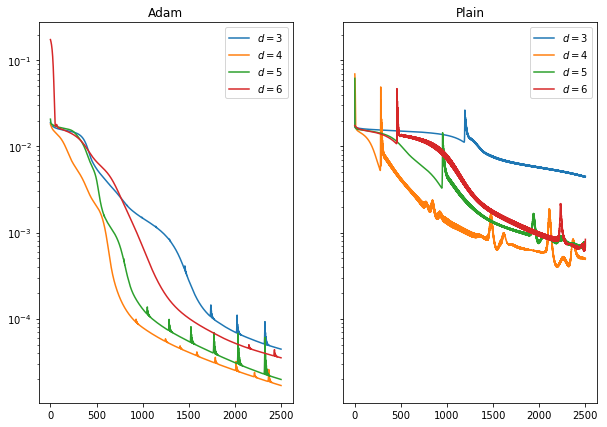

In [54]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)

#plot adam
ax = axs[0]
for i in range(len(d_0_list)):
    d0 = d_0_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ad, itr_A0 = readParams(K, d0, batchsize, N, filename = filenames_d_A[i])
    ax.plot(np.linspace(0,N,N), J_Ad/batchsize, label = r"$d ={}$".format(d0))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


#plot plain
ax = axs[1]
for i in range(len(d_0_list)):
    d0 = d_0_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pd, itr_P0 = readParams(K, d0, batchsize, N, filename = filenames_d_P[i])
    ax.plot(np.linspace(0,N,N), J_Pd/batchsize, label = r"$d ={}$".format(d0))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

In [ ]:
OLD BELOW

#### 3.5 The stepsize $h$

In [30]:
#define variables for this test
batchsize = I_0
d_0 = p0_tilde.shape[0]
h_list = np.array([0.05, 0.1, 0.15, 0.2])
tau = 0.001 
K = 50 

#define lists of filenames where the trained parameters will be stored
filenames_h_A = []
filenames_h_P = []
for i in range(len(h_list)):
    h = h_list[i]
    filenames_h_A.append('trainingParams_Ah_{}'.format(h))
    filenames_h_P.append('trainingParams_Ph_{}'.format(h))

In [31]:
for i in range(len(h_list)):
    h = h_list[i]
    #train for different stepsizes h with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Ah, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ah, itr_A0, filename = filenames_h_A[i])
    
    #train for different stepsizes h with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Ph, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ph, itr_P0, filename = filenames_h_P[i])

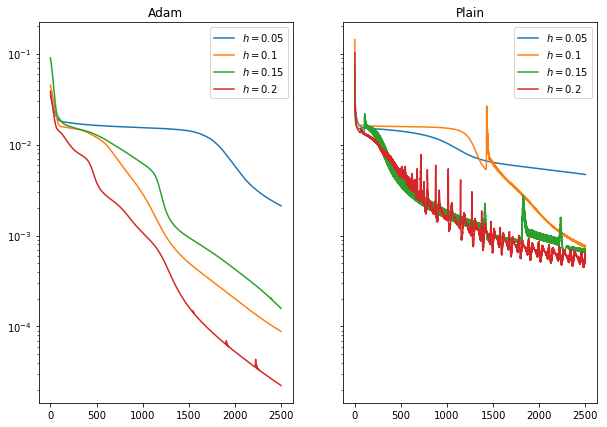

In [35]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_figheight(7)
fig.set_figwidth(10)
ax = axs[0]

#plot adam
for i in range(len(h_list)):
    h = h_list[i]
    W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ah, itr_A0 = readParams(K, d_0, batchsize, N, filename = filenames_h_A[i])
    ax.plot(np.linspace(0,N,N), J_Ah/batchsize, label = r"$h ={}$".format(h))
ax.set_title("Adam")
ax.set_yscale("log")
ax.legend()


ax = axs[1]
#plot plain
for i in range(len(h_list)):
    h = h_list[i]
    W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ph, itr_P0 = readParams(K, d_0, batchsize, N, filename = filenames_h_P[i])
    ax.plot(np.linspace(0,N,N), J_Ph/batchsize, label = r"$h ={}$".format(h))
ax.set_title(r"Plain")
ax.set_yscale("log")
ax.legend()
    
plt.show()

### 4. Training and testing with suggested functions

In [ ]:
#defines global variables for all the following tests
h = 0.1       #stepsize
tau = 0.001   #learning parameter
tol = 1e-5  #tolerance
N = 5000      #number of training series
K = 50        #number of hidden layers

#### 4.1  $F(y) = 1-\cos{y}$

In [ ]:
def F(y):
    return 1-np.cos(y)

In [ ]:
#define variable used for training with F(y)
d_F = 4        
I_F = 1000 

#define and scale input data ....AND FASIT
Y0_F = np.random.uniform(-2,2,(1,I_F))
c_F = F(Y0_F)
Y0_F_tilde = Y0_F
c_F_tilde, ac_F, bc_F = scale(c_F)

In [ ]:
#training for F(y)
mu_F, omega_F, W_F, b_F, J_F, ypsilon_F, itr_F = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_F, "adam")

#stores the trained parameters in file
writeParams(W_F, b_F, omega_F, mu_F,ypsilon_F, J_F, itr_F, filename = 'trainingParams_F.txt')

In [ ]:
#read the stored trained parameters
W_Fr,b_Fr,omega_Fr,mu_Fr,ypsilon_Fr, J_F, itr_F = readParams(K, d_F, I_F, N, filename='trainingParams_F.txt')

In [ ]:
#
plt.plot(np.linspace(0,itr_F,itr_F), J_F[:itr_F]/I_F)
plt.yscale('log')
plt.show()

In [ ]:
#testing with F(y)
YTest_F = np.random.uniform(-2,2,(1,I_F))
cTest_F = F(YTest_F)


ypsilonTest_F = testing(YTest_F, cTest_F, W_F, b_F, omega_F, mu_F, K, d_F, I_F, h, sigma, eta)

plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F, "*", label = "test")
plt.plot(YTest_F[0], cTest_F[0], "*", label = "fasit")
plt.legend()
plt.show()

#### 4.2 $G(y_1,y_2) = \frac{1}{2} (y_1^2 + y_2^2)$

In [ ]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [ ]:
#define variable used for training with G(y)
d_G = 4       
I_G = 1000    

#training with G(y)
Y0_G = np.random.uniform(-2,2,(2,I_G))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I_G)

Y0_G_tilde = Y0_G
c_G_tilde, ac_G, bc_G = scale(c_G)

In [ ]:
#training for G(y)
mu_G, omega_G, W_G, b_G, J_G, ypsilon_G, itr_G = trainingAlgorithm(K, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_G, "adam")
writeParams(W_G, b_G, omega_G, mu_G, ypsilon_G, J_G, itr_G, filename = 'trainingParams_G.txt')

In [ ]:
W_Gr,b_Gr,omega_Gr,mu_Gr, ypsilon_Gr, J_G, itr_G = readParams(K, d_G, I_G, N, filename='trainingParams_G.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_G,itr_G), J_G[:itr_G]/I_G)
plt.yscale("log")
plt.show()

In [ ]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

ypsilonTest_G = testing(YTest_G, cTest_G, W_G, b_G, omega_G, mu_G, K, d_G, I_G, h, sigma, eta)


#plotting of G(y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "test", depthshade = True)
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "test" , c="red", depthshade = False)
plt.show()

x = np.arange(0, I_G)
plt.plot(x, ypsilonTest_G, label ="test")
plt.plot(x, cTest_G[0], label = "fasit")
plt.legend()
plt.show()

#### 4.3 Known Hamiltonian 

#### 4.4 Unknown Hamiltonian

In [ ]:
trainingBatch = concatenate(0,25)

In [ ]:
dT = trainingBatch['P'].shape[0]
IT = trainingBatch['P'].shape[1]
batchsize = 50000

pT_tilde = trainingBatch['P']
TT_tilde, aTT, bTT = scale(trainingBatch['T'])
TT_tilde.resize(1,TT_tilde.shape[0])

In [ ]:
mu_T, omega_T, W_T, b_T, J_T, ypsilon_T, itr_T = trainingAlgorithm(K, dT, h, tau, pT_tilde, TT_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
writeParams(W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T, filename = 'trainingParams_T.txt')

In [ ]:
W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T = readParams(K, dT, batchsize, N, filename='trainingParams_T.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_T,itr_T), J_T[:itr_T]/batchsize)
plt.yscale("log")
plt.show()

### 5. Computing the gradient 

In [ ]:
def getZ_oneData(y,W,b,K,h,sigma):
    d = y.shape[0]
    I = y.shape[1]
    Z = np.zeros((K,d,I))
    Z[0] = y
    
    for k in range(1,K):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def gradF(y, omega, mu, W, b, K, sigma, eta_div, sigma_div):
    Z = getZ_oneData(y, W, b, K, h, sigma)
    A = eta_div(np.transpose(Z[K-1])@omega + mu)*omega 
    for k in range(K-1,0,-1): 
        B = h*sigma_div(W[k]@y+b[k])
        u = B*A
        A = A + W[k]@u
    return A

### 6. Numerical methods 

In [ ]:
def symplecticEuler(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 

    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 

        q[n+1] = q[n] + delta_t*gradF(p[n], omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = p[n] - delta_t*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

In [ ]:
def Stromer_Verlet(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 
    
    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 
        u = p[n] - delta_t/2*gradF(q[n], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #u = p_{n+1/2}, dVdq
        q[n+1] = q[n] + delta_t*gradF(u, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = u - delta_t/2*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

#### 6.1 Nonlinear pendulum

In [ ]:
m = 10E-3
l = 0.5
g = 9.81

def T_pend(p):
    return 0.5*p**2

def V_pend(q):
    return m*g*l*(1-np.cos(q))

In [ ]:
I_p = 1000
d_p = 2

q_p = np.random.uniform(0,2*np.pi,(1,I_p))
V_p = V_pend(q_p)
V_p_tilde, aVp, bVp = scale(V_p)

In [ ]:
W_Tpend,b_Tpend,omega_Tpend,mu_Tpend,ypsilon_Tpend, J_Tpend, itr_Tpend = readParams(K, d_p, I_p, N, filename='trainingParams_Tp.txt')
W_Vpend,b_Vpend,omega_Vpend,mu_Vpend,ypsilon_Vpend, J_Vpend, itr_Vpend = readParams(K, d_p, I_p, N, filename='trainingParams_Vp.txt')

In [ ]:
q0 = np.zeros((d_p,1))
p0 = np.zeros((d_p,1))
t = np.linspace(0,10,100)

q_sympEuler, p_sympEuler = symplecticEuler(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

q_StromerVerlet, p_StromerVerlet = Stromer_Verlet(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

In [ ]:
q_plot = np.append(np.flip(q_sympEuler[:,0,:]),q_sympEuler[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Symplectic Euler")


plt.legend()


In [ ]:
q_plot = np.append(np.flip(q_StromerVerlet[:,0,:]),q_StromerVerlet[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Stromer Verlet")


plt.legend()
